In [1]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode

load_dotenv()


class ChildState(TypedDict):
    messages: Annotated[list, add_messages]


search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm = ChatGroq(model_name="llama3-8b-8192")

llm_with_tools = llm.bind_tools(tools=tools)


def agent(state: ChildState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


def tool_router(state: ChildState):
    last_message = state["messages"][-1]

    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        return "tool_node"
    else:
        return END


tool_node = ToolNode(tools=tools)

subgraph = StateGraph(ChildState)

subgraph.add_node("agent", agent)
subgraph.add_node("tool_node", tool_node)

subgraph.set_entry_point("agent")
subgraph.add_conditional_edges(
    "agent", tool_router, {"tool_node": "tool_node", END: END}
)
subgraph.add_edge("tool_node", "agent")

search_app = subgraph.compile()

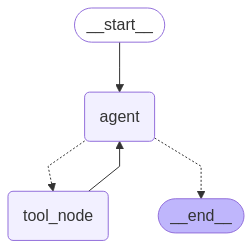

In [2]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        search_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [3]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END, START
from langchain_core.messages import AIMessage, HumanMessage


class ParentState(TypedDict):
    messages: Annotated[list, add_messages]


parent_graph = StateGraph(ParentState)
parent_graph.add_node("search_agent", search_app)
parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent", END)

parent_app = parent_graph.compile()

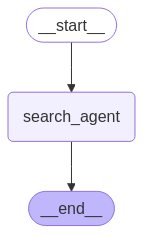

In [5]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        parent_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [6]:
# Case 2 : different schema

from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END, START
from langchain_core.messages import AIMessage, HumanMessage


class QueryState(TypedDict):
    query: str
    response: str


def search_agent(state: QueryState):
    subgraph_input = {"messages": [HumanMessage(content=state["query"])]}

    subgraph_result = search_app.invoke(subgraph_input)

    assistant_message = subgraph_result["messages"][-1]
    return {"response": assistant_message.content}


parent_graph2 = StateGraph(QueryState)
parent_graph2.add_node("search_agent", search_agent)

parent_graph2.add_edge(START, "search_agent")
parent_graph2.add_edge("search_agent", END)

parent_app2 = parent_graph2.compile()

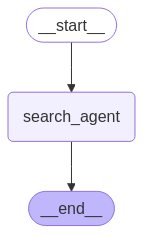

In [7]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(parent_app2.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API))
)